In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df_total = pd.read_excel("komtopp50_2020.xlsx", header = 6, usecols="A:F", sheet_name="Totalt")
df_male = pd.read_excel("komtopp50_2020.xlsx", header = 6, usecols="A:F", sheet_name="Män")
df_female = pd.read_excel("komtopp50_2020.xlsx", header = 6, usecols="A:F", sheet_name="Kvinnor")

df_total = df_total.rename(columns={2020: "Rang 2020",2019: "Rang 2019", "Unnamed: 2": "Kommun",'2020.1': "Folkmängd 2020",'2019.1': "Folkmängd 2019",'%': "Förändring"})
df_male = df_male.rename(columns={2020: "Rang 2020",2019: "Rang 2019", "Unnamed: 2": "Kommun",'2020.1': "Folkmängd 2020",'2019.1': "Folkmängd 2019",'%': "Förändring"})
df_female = df_female.rename(columns={2020: "Rang 2020",2019: "Rang 2019", "Unnamed: 2": "Kommun",'2020.1': "Folkmängd 2020",'2019.1': "Folkmängd 2019",'%': "Förändring"})

df_male["Kön"] = "Man"
df_female["Kön"] = "Kvinna"


df_all = pd.concat([df_male, df_female], ignore_index=True)

for col in ["Folkmängd 2020", "Folkmängd 2019", "Förändring"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

df_all_pivot = df_all.pivot_table(
    index="Kommun",
    columns="Kön",
    values=["Folkmängd 2020", "Folkmängd 2019", "Förändring"],
    aggfunc="sum"
).reset_index()

df_all_pivot.columns = [f"{col[1]} {col[0]}" if col[1] else col[0] for col in df_all_pivot.columns]

df_all_pivot["Total Pop 2020"] = df_all_pivot["Man Folkmängd 2020"] + df_all_pivot["Kvinna Folkmängd 2020"]
df_all_pivot["Total Pop 2019"] = df_all_pivot["Man Folkmängd 2019"] + df_all_pivot["Kvinna Folkmängd 2019"]

df_all_pivot["Total förändring"] = ((df_all_pivot["Total Pop 2020"] - df_all_pivot ["Total Pop 2019"]) / df_all_pivot["Total Pop 2019"] * 100)
df_total_summary = df_all_pivot[["Kommun", "Total Pop 2020", "Total Pop 2019", "Total förändring"]]

df_merged = df_all.merge(
    df_total_summary,
    on="Kommun",
    how="left"
)

df_merged = df_merged[
    [
        "Kommun",
        "Folkmängd 2020",
        "Folkmängd 2019",
        "Förändring",
        "Kön",
        "Total Pop 2020",
        "Total Pop 2019",
        "Total förändring"
    ]
]



In [3]:
df_merged = df_merged.sort_values(
    by=["Total Pop 2020", "Kommun", "Folkmängd 2020"],
    ascending=[False, True, False],
    ignore_index=True
)
df_merged.head(6)

,Kommun,Folkmängd 2020,Folkmängd 2019,Förändring,Kön,Total Pop 2020,Total Pop 2019,Total förändring
0,Stockholm,492569,491853,0.145572,Kvinna,975551,974073,0.151734
1,Stockholm,482982,482220,0.158019,Man,975551,974073,0.151734
2,Göteborg,292505,290308,0.756782,Man,583056,579281,0.651670
3,Göteborg,290551,288973,0.546072,Kvinna,583056,579281,0.651670
4,Malmö,175411,173543,1.076390,Kvinna,347949,344166,1.099179
5,Malmö,172538,170623,1.122357,Man,347949,344166,1.099179


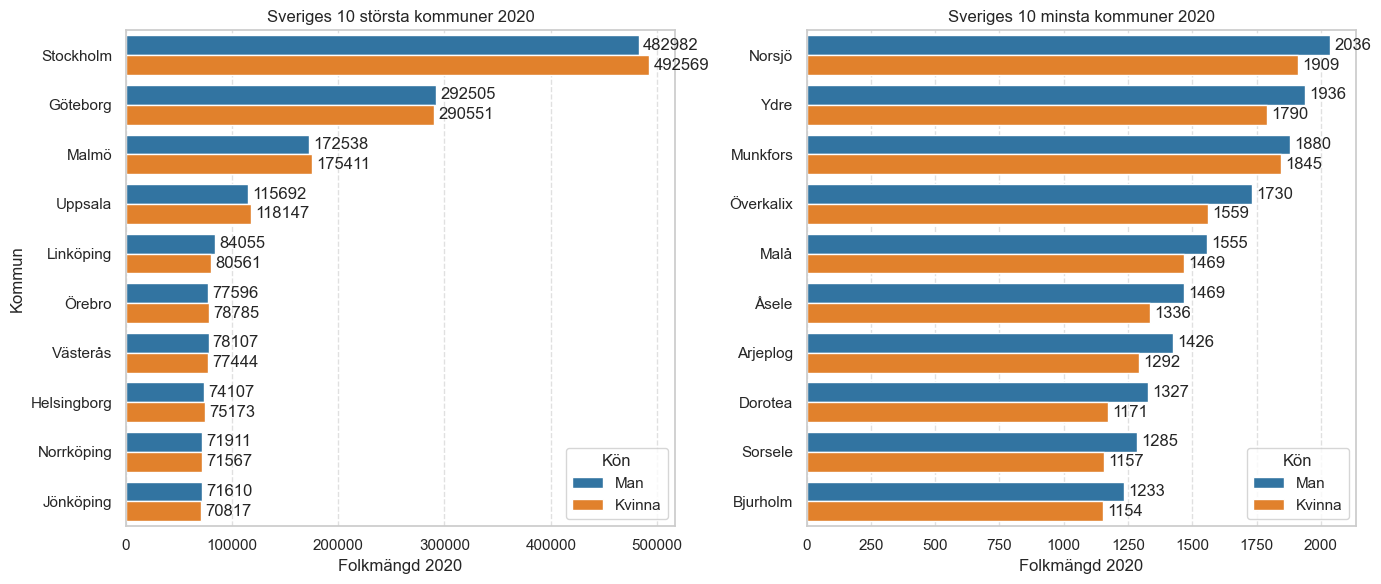

In [4]:
top10 = df_merged[["Kommun", "Total Pop 2020"]].drop_duplicates("Kommun").nlargest(10, "Total Pop 2020")["Kommun"]
bottom10 = df_merged[["Kommun", "Total Pop 2020"]].drop_duplicates("Kommun").nsmallest(10, "Total Pop 2020")["Kommun"]

storst10 = df_merged[df_merged["Kommun"].isin(top10)]
minst10 = df_merged[df_merged["Kommun"].isin(bottom10)]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(
    data=storst10,
    x="Folkmängd 2020",
    y="Kommun",
    hue="Kön",
    ax=axes[0],
    hue_order=["Man", "Kvinna"],
    palette={"Man": "#1f77b4", "Kvinna": "#ff7f0e"},
    order=storst10.groupby("Kommun")["Folkmängd 2020"].sum().sort_values(ascending=False).index
)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.0f", label_type="edge", padding=3)

axes[0].set_title("Sveriges 10 största kommuner 2020")
axes[0].set_xlabel("Folkmängd 2020")
axes[0].set_ylabel("Kommun")

sns.barplot(
    data=minst10,
    x="Folkmängd 2020",
    y="Kommun",
    hue="Kön",
    ax=axes[1],
    hue_order=["Man", "Kvinna"],
    palette={"Man": "#1f77b4", "Kvinna": "#ff7f0e"},
    order=minst10.groupby("Kommun")["Folkmängd 2020"].sum().sort_values(ascending=False).index,
    
)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.0f", label_type="edge", padding=3)

axes[1].set_title("Sveriges 10 minsta kommuner 2020")
axes[1].set_xlabel("Folkmängd 2020")
axes[1].set_ylabel("")

for ax in axes:
    ax.legend(title="Kön")
    ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


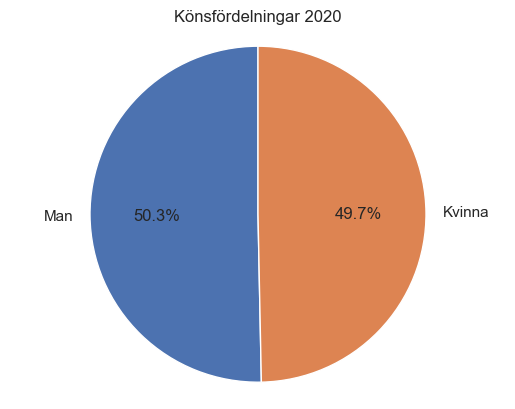

In [5]:
df_merged.groupby("Kön")["Folkmängd 2020"].sum()
andelar = df_merged.groupby("Kön")["Folkmängd 2020"].sum() / df_merged["Folkmängd 2020"].sum()
andelar = andelar[::-1]

fig, ax = plt.subplots()
ax.pie(andelar, labels=andelar.index, autopct="%.1f%%", startangle=90);
ax.set_title("Könsfördelningar 2020")
ax.axis("equal")
plt.show()


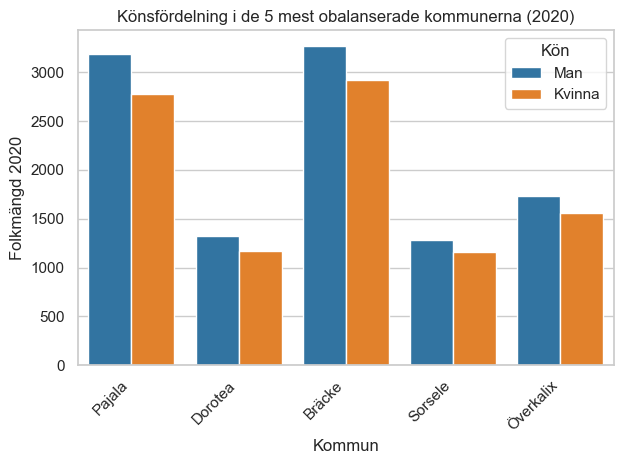

In [14]:
df_pivot_difference = df_merged.pivot(index="Kommun", columns="Kön", values="Folkmängd 2020")

df_pivot_difference["Skillnad %"] = (
    (df_pivot_difference["Man"] - df_pivot_difference["Kvinna"]).abs() /
    (df_pivot_difference["Man"] + df_pivot_difference["Kvinna"]) * 100
)
top5_diff = df_pivot_difference.sort_values("Skillnad %", ascending=False).head(5)

top5_melt = top5_diff[["Man", "Kvinna"]].reset_index().melt(id_vars="Kommun", var_name="Kön", value_name="Folkmängd 2020"
)

sns.barplot(
    data=top5_melt,
    x="Kommun",
    y="Folkmängd 2020",
    hue="Kön",
    hue_order=["Man", "Kvinna"],
    palette={"Man": "#1f77b4", "Kvinna": "#ff7f0e"}
)
plt.title("Könsfördelning i de 5 mest obalanserade kommunerna (2020)")
plt.xlabel("Kommun")
plt.ylabel("Folkmängd 2020")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


